In [1]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib as mpl

import os, sys
import pickle as pkl
from scipy import interpolate
import scipy as sp
import copy

sys.path.append(r"C:\Users\mikek\OneDrive\Project\DLS\DLS-git")
from LRBv21 import LRBv21
from AnalyticCoolingCurves import *
from unpackConfigurationsMK import *
from refineGrid import refineGrid
from Morph import Profile, Morph

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))

from DLS.postprocess import *

from code_comparison.solps_pp import *
import general.plotstyle

%matplotlib inline

%load_ext autoreload
%autoreload 2


## N, Ne, Ar

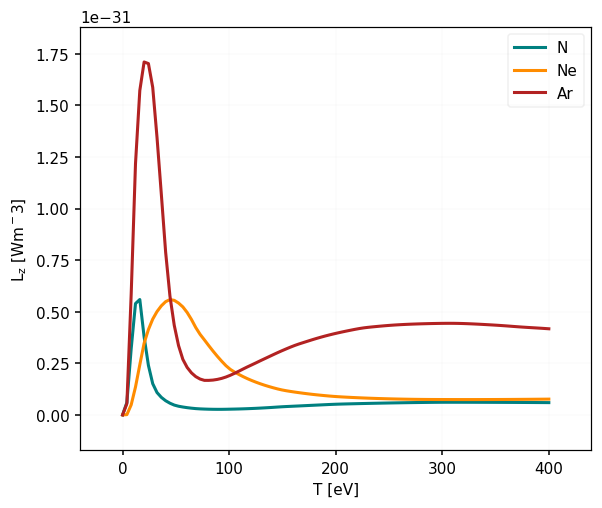

In [5]:
T = np.linspace(0,400,100)
fig, ax = plt.subplots()

ax.plot(T, [LfuncKallenbach("N")(x) for x in T], lw = 2,  label = r"N")
ax.plot(T, [LfuncKallenbach("Ne")(x) for x in T], lw = 2, label = "Ne")
ax.plot(T, [LfuncKallenbach("Ar")(x) for x in T], lw = 2, label = "Ar")
ax.set_xlabel("T [eV]")
ax.set_ylabel("$L_z$ [$W m^-3$]")
ax.legend()

# Read balance file

In [3]:
balance_path = r"C:\Users\mikek\OneDrive\Project\DLS\from_stuart\2023-07-11 - SPR45 balance file\balance.nc"
eqb = dict()
eqb["SPR45"] = dict()

for res in [10000, 100000]:
    eqb["SPR45"][res] = dict()
    
    for side in ["il", "ol", "iu", "ou"]: # Inner lower, outer lower.
        eqb["SPR45"][res][side] = unpackConfigurationMK(File = balance_path, Type = side, sepadd=0, resolution = res)
        
        keys = list(eqb["SPR45"][res][side].keys())
        for key in keys:
            
            if key not in ["Bpol", "Btot", "Xpoint", "Spol", "S", "R", "Z"]:
                eqb["SPR45"][res][side].pop(key, None)
        
# file_write(eqb, "equilibrium_100k.pkl")

# Setup and run DLS

In [6]:
# results = dict()

#set switches
radios_default = {
    "ionisation": False,  # WIP - do not use. in development
    "upstreamGrid": True, # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # WIP - do not use. if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants_default = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "Tt": 0.5, # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
    
    "qpllu0": 1e9, # heat flux density at the x point
    "nu" : 1e20, # Upstream density (if constant)
    "nu0" : 1e20, # Upstream density (if constant)
    "cz0" : 0.02, # Impurity fraction (if constant)
    
    "Lfunc": LfuncKallenbachAr, # impurity cooling function. More are available in AnalyticCoolingCurves.py
    "alpha": 1000, # WIP - do not use. flux limiting alpha. Only matters if fluxlim is true
}

# Run

## Impurities

In [7]:
cvar = "density"
design = "SPR45"
side = "ol"

store_impurity = dict()


for impurity in ["N", "Ne", "Ar"]:
# for w_factor in [0.005]:
    d = eqb["SPR45"][10000][side].copy()
    constants = constants_default.copy() # Set settings to default
    radios = radios_default.copy() # Set settings to default
    SparRange = np.linspace(0, d["S"][d["Xpoint"]], 10) # Don't solve up to xpoint cause it won't like it with narrow curves

    # SparRange = [d["S"][d["Xpoint"]]]
    ## Unmitigated SPR45 peak power loads + 0.
    if "i" in side:
        constants["qpllu0"] = 1.5e9
    elif "o" in side:
        constants["qpllu0"] = 2e9
          
    constants["Lfunc"] = LfuncKallenbach(impurity) 

    results = LRBv21(constants, radios, d, SparRange, verbosity = 0, 
                     control_variable = cvar, 
                     Ctol = 1e-3, 
                     Ttol=1e-3,
                     dynamicGrid = True,
                    dynamicGridRefinementRatio = 30)

    store_impurity[impurity] = copy.deepcopy(results)
    

Solving...0.00...5.80...11.59...17.39...23.19...28.98...34.78...40.58...46.37...52.17...Complete in 72.7 seconds
Solving...0.00...5.80...11.59...17.39...23.19...28.98...34.78...40.58...46.37...52.17...Complete in 70.7 seconds
Solving...0.00...5.80...11.59...17.39...23.19...28.98...34.78...40.58...46.37...

c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


52.17...Complete in 77.7 seconds


In [ ]:
write_file(store, "2024-03-04 - Parametric cooling curves.pkl")

In [96]:
%matplotlib inline
plt.close("all")

# Profile histories

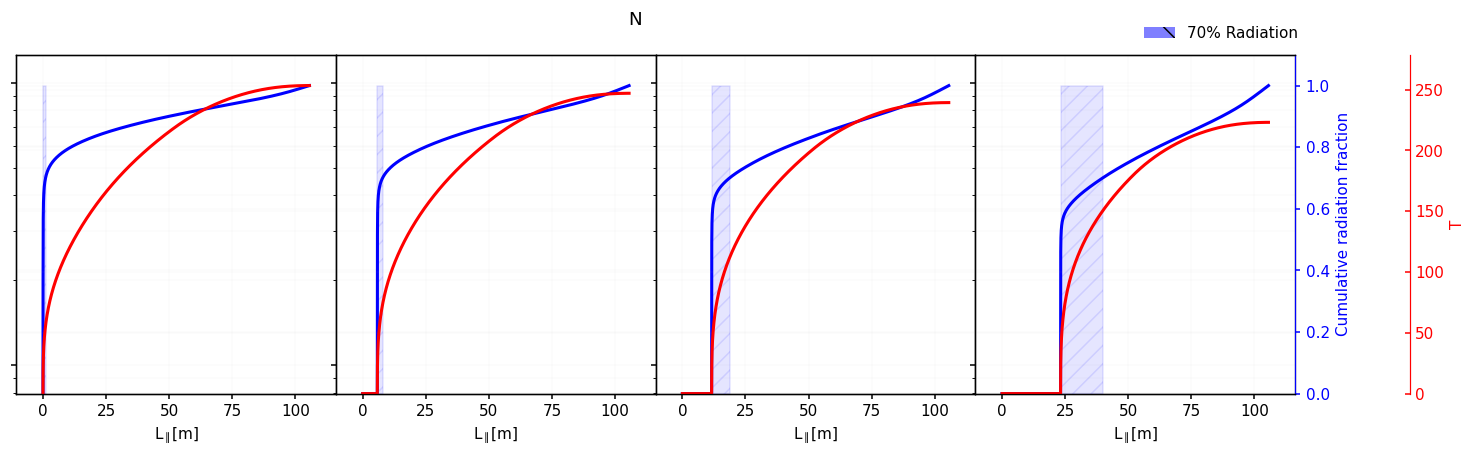

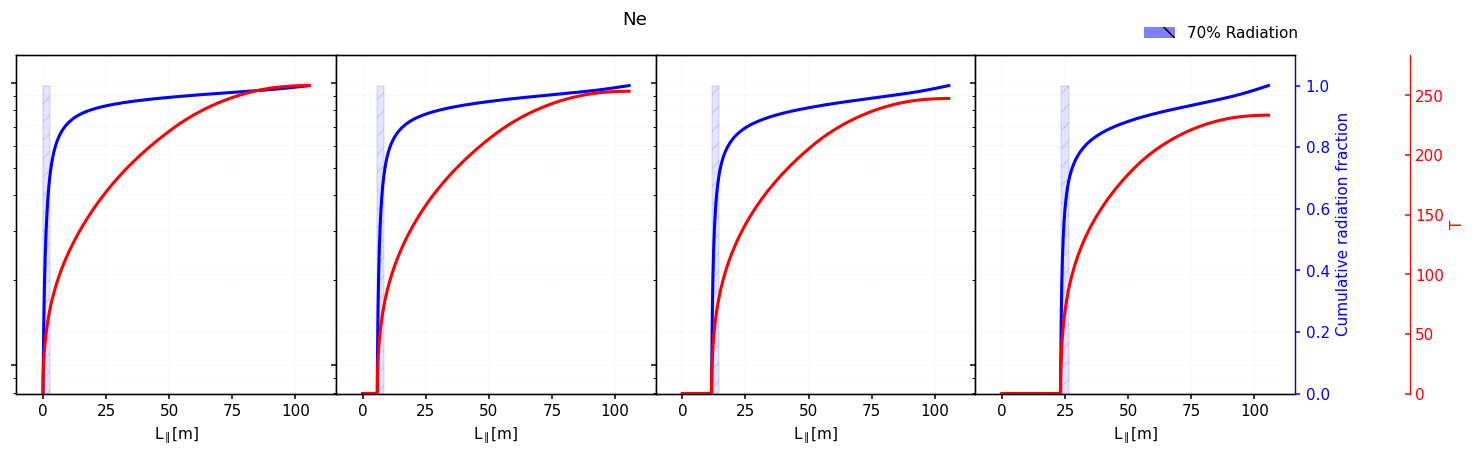

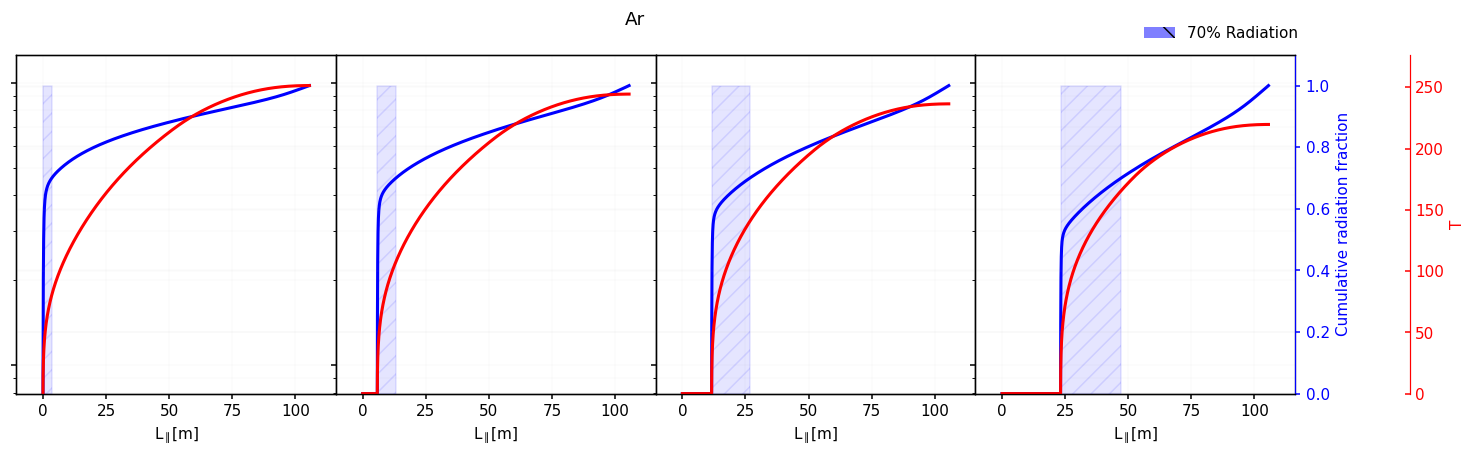

In [8]:
for case in store_impurity.keys():
    p = eqb["SPR45"][10000]["ol"]
    s = store_impurity[case]
    plot_profile_histories(p, s, [0, 1, 2, 4], rad_threshold = 0.7, mode = "temp", title = f"{case}")

# Postprocess front performance

In [ ]:
i = 0

Spol = s["Spolprofiles"][i]
S = s["Sprofiles"][i]
Btot = s["Btotprofiles"][i]
Bpol = s["Bpolprofiles"][i]
Xpoint = s["Xpoints"][i]
q = pad_profile(S, s["Qprofiles"][i])  # W/m2
T = pad_profile(S, s["Tprofiles"][i])
R = pad_profile(S, s["Rprofiles"][i])

Rtot = sp.integrate_trapezoid(y = R, x = S)


## Impurity

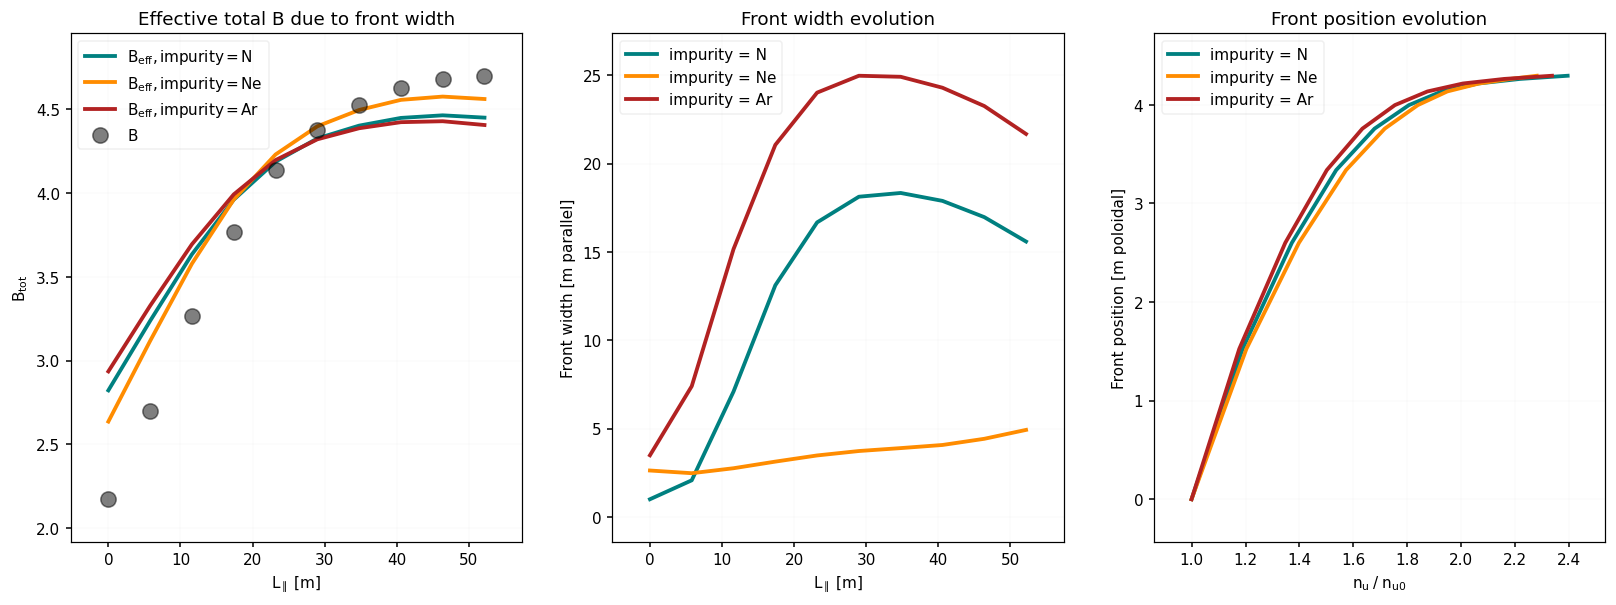

In [9]:
p = eqb["SPR45"][10000]["ol"]
store = store_impurity

fig, axes = plt.subplots(1,3, figsize = (18,6))



for impurity in store.keys():

    s = store[impurity]
    df = get_front_widths(p = p, s = s, Rcutoff = 0.7, use_prad = True)

    R = s["Rprofiles"][0]
    B = p["Btot"]
    Rint = sp.integrate.trapezoid(y = R, x = p["S"])
    Beff = sp.integrate.trapezoid(y = R*B, x = p["S"]) / Rint

    axes[0].plot(df["Spar"], df["Btot_eff"], label = f"$B_{{eff}}, impurity = {impurity}$", lw = 2.5)
    axes[1].plot(df["Spar"], df["Spar_front_width"], label = f"impurity = {impurity}", lw = 2.5)
    axes[2].plot(df["crel"], df["Spol"], label = f"impurity = {impurity}", lw = 2.5)
    
axes[0].plot(df["Spar"], df["Btot"], label = "$B$", ms = 10, marker = "o", lw = 0, c = "k", alpha = 0.5)
    
axes[0].set_xlabel("$L_{\parallel}$ [m]")
axes[0].set_ylabel("$B_{tot}$")
axes[0].set_title("Effective total B due to front width")

axes[1].set_xlabel("$L_{\parallel}$ [m]")
axes[1].set_ylabel("Front width [m parallel]")
axes[1].set_title("Front width evolution")

axes[2].set_xlabel("$n_{u} \ /\  n_{u0}$")
axes[2].set_ylabel("Front position [m poloidal]")
axes[2].set_title("Front position evolution")

for ax in axes:
    ax.legend()
# ax.set_ylim(0,0.1e9)

# Comparison of shrinking vs. expanding front